# Transfer Learning

Based on **Patric Loeber** video: https://www.youtube.com/watch?v=c36lUUr864M&t=12990s

Transfer learning is a machine learning method where a model developed for a first task is then reused as the starting point for a model on a second task. For example we can train a model to classify birds and cats and then use the same model modified only a little bit in the last layer and then use the new model to classify bees and dogs. It is a popular approach in deep learning that allows rapid generation of new models. This is super important because training of a completely new model can be very time consuming, t can take multiple days or even weeks. So if we use a pre-trained model then we typically exchange only the last layer and then do not need to train the whole model again. However transfer learning can achieve pretty good performance results and that's why it's so popular nowadays.

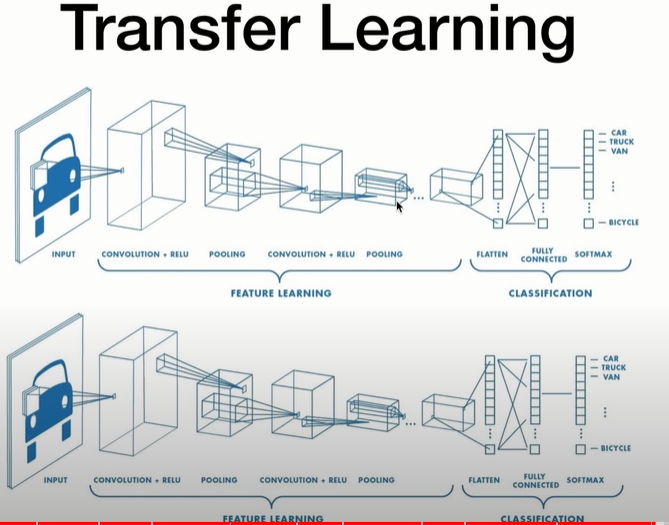

Here we have a typical CNN architecture. Let's say this has been already trained on a lot of data and we have the optimized weights and now we only want to take the last fully connected layer.

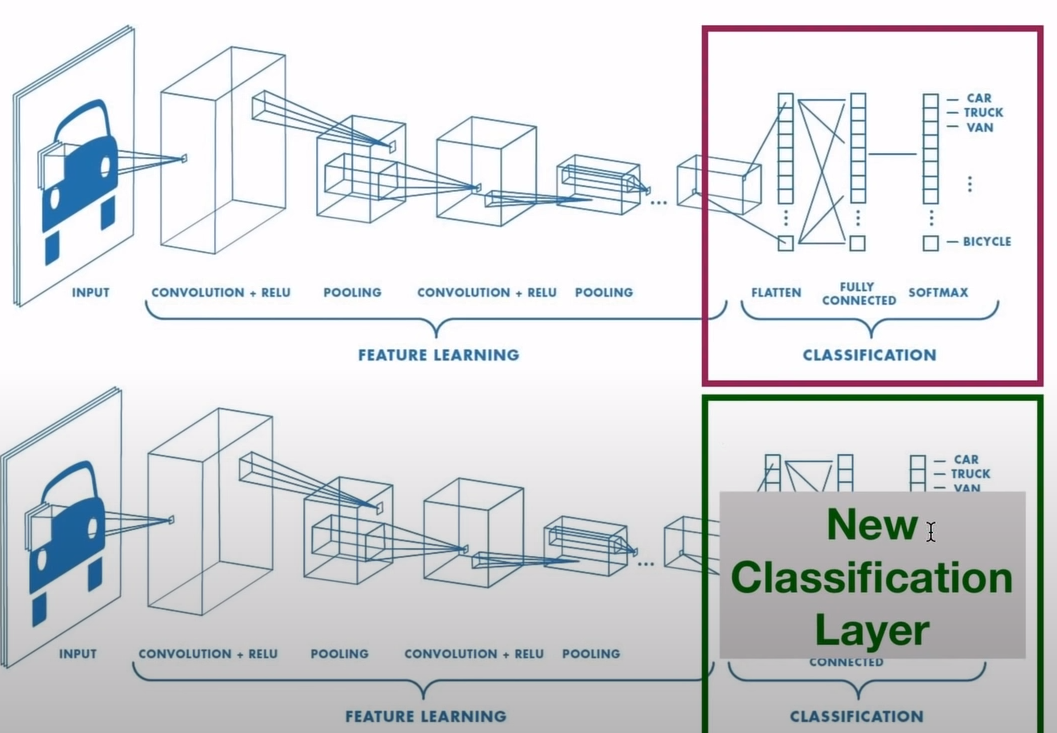

We take the red layer and then modify it and train the last layer on our new data. Then we have a new model that has been trained and tweaked in the last layer.

## Code

In this example we are using the pre-trained ResNet-18 convolutional neural network. ResNet-18 is trained on more than a milion images from the imagenet database. This network is 18 layers deep and can classify images into 1000 object categories. In our example we have only two classes so we only want to detect bees and ants.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [26]:
# import data
data_dir = 'data/hymenoptera_data'
sets = ['train', 'val']
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                 for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=0)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


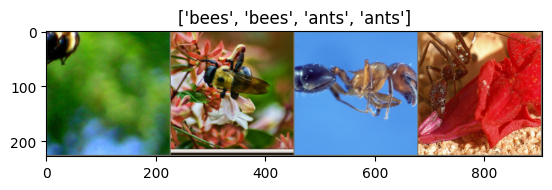

In [34]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [42]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
            
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")
        
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

We use technique that is called fine tuning because we train whole model again but only a little bit so we fine tune all the weights based on the new data and with the new last layer so this is one option.

In [43]:
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
# number of input features for the last layer
numftrs = model.fc.in_features

# giving a new fully connected layer
model.fc = nn.Linear(numftrs, 2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# scheduler
# step_size and gamma means that every step_size epochs our learning rate is multiplied by gamma
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)


Epoch 0/19
----------
train Loss: 0.6562 Acc: 0.6220
val Loss: 0.5193 Acc: 0.7908

Epoch 1/19
----------
train Loss: 0.4889 Acc: 0.7642
val Loss: 0.3660 Acc: 0.8758

Epoch 2/19
----------
train Loss: 0.4684 Acc: 0.7602
val Loss: 0.3143 Acc: 0.8954

Epoch 3/19
----------
train Loss: 0.4704 Acc: 0.7642
val Loss: 0.2889 Acc: 0.8954

Epoch 4/19
----------
train Loss: 0.4314 Acc: 0.7927
val Loss: 0.2811 Acc: 0.9085

Epoch 5/19
----------
train Loss: 0.3530 Acc: 0.8496
val Loss: 0.2378 Acc: 0.9216

Epoch 6/19
----------
train Loss: 0.4255 Acc: 0.8049
val Loss: 0.2417 Acc: 0.9216

Epoch 7/19
----------
train Loss: 0.3551 Acc: 0.8415
val Loss: 0.2444 Acc: 0.9085

Epoch 8/19
----------
train Loss: 0.3422 Acc: 0.8618
val Loss: 0.2330 Acc: 0.9150

Epoch 9/19
----------
train Loss: 0.3391 Acc: 0.8577
val Loss: 0.2211 Acc: 0.9150

Epoch 10/19
----------
train Loss: 0.3968 Acc: 0.8293
val Loss: 0.2295 Acc: 0.9150

Epoch 11/19
----------
train Loss: 0.2925 Acc: 0.8780
val Loss: 0.2285 Acc: 0.9150

Ep

As a second option what we can do is we can freeze all the layers in the beginning and only train the very last layer. For this we have to loop over all the parameters after we got our model. Even faster.

In [44]:
model_conv = models.resnet18(weights='ResNet18_Weights.DEFAULT')
for param in model_conv.parameters():
    # freezing all the layters in the beginning
    param.requires_grad = False
    
# number of input features for the last layer
numftrs = model_conv.fc.in_features

# giving a new fully connected layer
model_conv.fc = nn.Linear(numftrs, 2)
model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.parameters(), lr=0.001)

# scheduler
# step_size and gamma means that every step_size epochs our learning rate is multiplied by gamma
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_conv = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=20)


Epoch 0/19
----------
train Loss: 0.3912 Acc: 0.8171
val Loss: 0.2360 Acc: 0.9216

Epoch 1/19
----------
train Loss: 0.3264 Acc: 0.8780
val Loss: 0.2497 Acc: 0.9085

Epoch 2/19
----------
train Loss: 0.3190 Acc: 0.8699
val Loss: 0.2443 Acc: 0.9150

Epoch 3/19
----------
train Loss: 0.3372 Acc: 0.8415
val Loss: 0.2134 Acc: 0.9346

Epoch 4/19
----------
train Loss: 0.3617 Acc: 0.8496
val Loss: 0.2364 Acc: 0.9150

Epoch 5/19
----------
train Loss: 0.3189 Acc: 0.8374
val Loss: 0.2343 Acc: 0.9085

Epoch 6/19
----------
train Loss: 0.2853 Acc: 0.8780
val Loss: 0.2301 Acc: 0.9150

Epoch 7/19
----------
train Loss: 0.3498 Acc: 0.8537
val Loss: 0.2264 Acc: 0.9216

Epoch 8/19
----------
train Loss: 0.3506 Acc: 0.8577
val Loss: 0.2573 Acc: 0.9150

Epoch 9/19
----------
train Loss: 0.3796 Acc: 0.8049
val Loss: 0.2219 Acc: 0.9216

Epoch 10/19
----------
train Loss: 0.4257 Acc: 0.8130
val Loss: 0.2275 Acc: 0.9216

Epoch 11/19
----------
train Loss: 0.3105 Acc: 0.8902
val Loss: 0.2351 Acc: 0.9281

Ep